In [25]:
from scipy.io import loadmat
from scipy.io import savemat 
import os
import numpy as np
import matplotlib.pyplot as plt
from alphacsc import GreedyCDL
from alphacsc.utils import split_signal
from scipy import signal
from scipy.signal import butter, filtfilt
from matplotlib import gridspec
import time
from alphacsc import BatchCDL
from pathlib import Path

def butter_lowpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def butter_highpass(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high')
    y = filtfilt(b, a, data)
    return y

In [26]:
#################################################################
## all parameters are set here
#################################################################
ori_fs             = 1000 # Original sampling rate (Hz)
decimate           = 10   # dec factor for analysis data
HI_PASS            = 1    #Hz 
LOW_PASS           = 30   #Hz
fs                 = ori_fs // decimate  # decimated signal fs
n_atoms            = 30
ATOM_DURATION      = 3    # seconds
SPLIT_BLOCKS       = 8    # Spliting a long resting into x blocks
N_JOBS             = 80   # cdl jobs

# data in and out
SUBJ_DIR  = Path('/m/nbe/scratch/grr_epilepsy/MEG_spont')
SUBJS     = [file for file in os.listdir(SUBJ_DIR) if file.endswith('.npy')]
SUBJS     = sorted(SUBJS)

MAT_FILE_WRITEOUT  = Path('/m/nbe/scratch/grr_epilepsy/MEG_spont/results/')
MAT_FILE_WRITEOUT  = MAT_FILE_WRITEOUT / 'WHOLE_COHORT_CDL'

In [ ]:
t1 = time.time()
# for all subjects ##############################################################################
for subj in SUBJS:    

    t11=time.time()
    filePath = Path(SUBJ_DIR / subj)
    parcelTS = np.load(filePath) # data: channels x samples    
    PARC_N       = parcelTS.shape[0]
    SAMPLE_N     = signal.decimate(parcelTS[0], decimate).shape[0]
    bpTS         = np.zeros([PARC_N, SAMPLE_N])

    # band-pass the data, and decimate if need be #######################
    for i in np.arange(0,PARC_N):
        aParcelTS            = parcelTS[i]    
        lowpass_data         = butter_lowpass(aParcelTS, LOW_PASS, ori_fs)
        highpass             = butter_highpass(lowpass_data, HI_PASS, ori_fs)
        bpTS[i, :]           = signal.decimate(highpass, decimate)
    del lowpass_data
    print('Band-pass done, now fitting: '+subj+ '...')

    # Split a long trial into x blocks
    split_parcTS = split_signal(bpTS[None], SPLIT_BLOCKS)

    # Define the shape of the dictionary
    n_times_atom = int(round(fs * ATOM_DURATION)) 
    print('Data shape:', split_parcTS.shape, '; N of Atoms: ',  n_atoms, '; Sample per atom: ', n_times_atom)

    cdl = BatchCDL(
        # Shape of the dictionary
        n_atoms=n_atoms,
        n_times_atom=n_times_atom,
        # Request a rank1 dictionary with unit norm temporal and spatial maps
        rank1=True, uv_constraint='separate',
        # Initialize the dictionary with random chunk from the data
        D_init='chunk',
        # rescale the regularization parameter to be 20% of lambda_max
        lmbd_max="scaled", reg=.2,
        # Number of iteration for the alternate minimization and cvg threshold
        n_iter=100, eps=1e-4,
        # solver for the z-step
        solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
        # solver for the d-step
        solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
        # Technical parameters
        verbose=1, random_state=0, n_jobs=N_JOBS)
    

    ######################################### FIT IT   
    cdl.fit(split_parcTS)
    del split_parcTS   
    ######################################### FIT IT   


    u_hat = cdl.u_hat_ # spatial
    v_hat = cdl.v_hat_ # temporal
    z_hat = cdl.z_hat_ # scores
    #print(v_hat.shape)

    # save results
    writeoutPrefix =subj[0:13] + '_seg00_'
    matfile = MAT_FILE_WRITEOUT / (writeoutPrefix + '.mat')    

    FILENAME = (writeoutPrefix + '_BB_' + str(HI_PASS) + 
                '-' + str(LOW_PASS) + 'Hz_' + str(n_atoms) + 
                '_Atoms_' + str(ATOM_DURATION) + '(s).mat')
    MAT_FILE = MAT_FILE_WRITEOUT / FILENAME

    t12=time.time()
    print('\tTime spent:', round((t12-t11)/60,1), ' mins.' )
    timeSpent_min = round((t12-t11)/60,1)
    savemat(MAT_FILE, {"u_hat": u_hat, "v_hat": v_hat, 'z_hat': z_hat, 'fs': fs, 'timeSpent_min':timeSpent_min})
    print('Writing: ' + FILENAME)    


t2 = time.time()    
print('\nN of atoms: ', n_atoms, ', Num of Jobs: ', N_JOBS)
print('Low: ', LOW_PASS, 'Hz, High:', HI_PASS, 'Hz')
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t2))}")
print('Total time spent:', round((t2-t1)/60,1), ' mins.' ) 

Band-pass done, now fitting: grr0001_set02_v202412.npy...
Data shape: (8, 200, 16525) ; N of Atoms:  30 ; Sample per atom:  300
.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

..

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

..

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9


[BatchCDL] Converged after 16 iteration, (dz, du) = 9.957e-05, 9.540e-05
[BatchCDL] Fit in 3703.4s
	Time spent: 62.0  mins.
Writing: grr0001_set02_seg00__BB_1-30Hz_30_Atoms_3(s).mat
Band-pass done, now fitting: grr0001_set03_v202412.npy...
Data shape: (8, 200, 19187) ; N of Atoms:  30 ; Sample per atom:  300
.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9/prod/software/neuroimaging-env/2024-02/68c439f/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/appl/scibuilder-mamba/aalto-rhel9

.

In [23]:
(3698.3/3600)



1.0273055555555557

In [20]:
savemat(str(MAT_FILE), {"u_hat": u_hat, "v_hat": v_hat, 'z_hat': z_hat, 'fs': fs, 'timeSpent_min':timeSpent_min})

In [19]:
!ls /m/nbe/scratch/grr_epilepsy/MEG_spont/results/WHOLE_COHORT_CDL

ls: cannot access '/m/nbe/scratch/grr_epilepsy/MEG_spont/results/WHOLE_COHORT_CDL': No such file or directory


In [13]:
parcelTS.shape

(200, 613000)

In [124]:
# visualize the traces

VISUALIZE_TRACES = False

if VISUALIZE_TRACES:     
    BLOCK_SIZE = 5 # Seconds
    BLOCK_N    = 15
    plt.figure(figsize=(20, 25))
    for i in range(BLOCK_N):
        plt.subplot(BLOCK_N, 1, i+1)

        # gray: orig TS
        plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
                 aParcelTS[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k', alpha=0.33)

        # black: filtered data
        plt.plot(np.linspace(0, BLOCK_SIZE, ori_fs*BLOCK_SIZE), 
                 highpass[i*ori_fs*BLOCK_SIZE:(i+1)*ori_fs*BLOCK_SIZE], 'k')

        # red: filtered and decimated
        plt.plot(np.linspace(0, BLOCK_SIZE, fs*BLOCK_SIZE), data[i*fs*BLOCK_SIZE:(i+1)*fs*BLOCK_SIZE], 'r')
    

In [125]:
PARC_N       = parcelTS.shape[0]
SAMPLE_N     = signal.decimate(parcelTS[0], decimate).shape[0]
bpTS         = np.zeros([PARC_N, SAMPLE_N])


# band-pass the data, and decimate if need be #######################
for i in np.arange(0,200):
    
    aParcelTS            = parcelTS[i]    
    lowpass_data         = butter_lowpass(aParcelTS, LOW_PASS, ori_fs)
    highpass             = butter_highpass(lowpass_data, HI_PASS, ori_fs)
    bpTS[i, :]           = signal.decimate(highpass, decimate)
    
del lowpass_data
print('Band-pass done for the parcel time series, now you can fit it with BatchCDL!')

Band-pass done for the parcel time series, now you can fit it with BatchCDL!


In [21]:
split_parcTS = split_signal(bpTS[None], 8)

# Define the shape of the dictionary
n_times_atom = int(round(fs * ATOM_DURATION)) 
print('Data shape:', split_parcTS.shape, '; n_times_atom: ', n_times_atom)


cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=10, random_state=0, n_jobs=N_JOBS)



######################################### FIT ITsplit_parcTS = split_signal(bpTS[None], 8)

# Define the shape of the dictionary
n_times_atom = int(round(fs * ATOM_DURATION)) 
print('Data shape:', split_parcTS.shape, '; n_times_atom: ', n_times_atom)


cdl = BatchCDL(
    # Shape of the dictionary
    n_atoms=n_atoms,
    n_times_atom=n_times_atom,
    # Request a rank1 dictionary with unit norm temporal and spatial maps
    rank1=True, uv_constraint='separate',
    # Initialize the dictionary with random chunk from the data
    D_init='chunk',
    # rescale the regularization parameter to be 20% of lambda_max
    lmbd_max="scaled", reg=.2,
    # Number of iteration for the alternate minimization and cvg threshold
    n_iter=100, eps=1e-4,
    # solver for the z-step
    solver_z="lgcd", solver_z_kwargs={'tol': 1e-2, 'max_iter': 1000},
    # solver for the d-step
    solver_d='alternate_adaptive', solver_d_kwargs={'max_iter': 300},
    # Technical parameters
    verbose=10, random_state=0, n_jobs=N_JOBS)



######################################### FIT IT
print('Start fitting now ...')
t1 = time.time()
cdl.fit(split_parcTS)
del split_parcTS   
######################################### FIT IT

t2 = time.time()

print('\nN of atoms: ', n_atoms, ', Num of Jobs: ', N_JOBS)
print('Low: ', LOW_PASS, 'Hz, High:', HI_PASS, 'Hz')
print(f"Finished at: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(t2))}")
print('Time spent:', (t2-t1)/60, ' mins.' )

Data shape: (8, 200, 7662) ; n_times_atom:  200
Data shape: (8, 200, 7662) ; n_times_atom:  200
Start fitting now ...
[BatchCDL] CD iterations 0 / 100
[BatchCDL] lambda = 2.270e+01
[BatchCDL] Objective (z) : 6.057e+06 (sparsity: 3.371e-03)
[BatchCDL] Objective (d) : 6.019e+06
[BatchCDL] CD iterations 1 / 100
[BatchCDL] Objective (z) : 5.992e+06 (sparsity: 3.759e-03)
[BatchCDL] Objective (d) : 5.979e+06
[BatchCDL] CD iterations 2 / 100
[BatchCDL] Objective (z) : 5.970e+06 (sparsity: 3.947e-03)
[BatchCDL] Objective (d) : 5.962e+06
[BatchCDL] CD iterations 3 / 100
[BatchCDL] Objective (z) : 5.957e+06 (sparsity: 4.010e-03)
[BatchCDL] Objective (d) : 5.952e+06
[BatchCDL] CD iterations 4 / 100
[BatchCDL] Objective (z) : 5.948e+06 (sparsity: 4.109e-03)
[BatchCDL] Objective (d) : 5.945e+06
[BatchCDL] CD iterations 5 / 100
[BatchCDL] Objective (z) : 5.942e+06 (sparsity: 4.196e-03)
[BatchCDL] Objective (d) : 5.939e+06
[BatchCDL] CD iterations 6 / 100
[BatchCDL] Objective (z) : 5.937e+06 (sparsit

(12, 200)


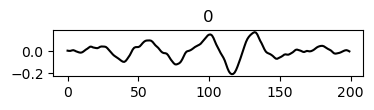

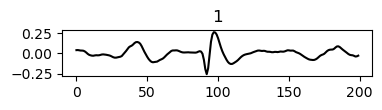

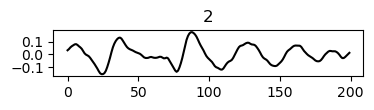

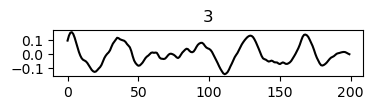

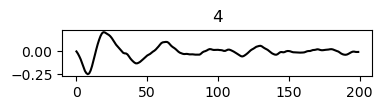

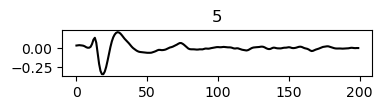

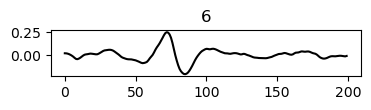

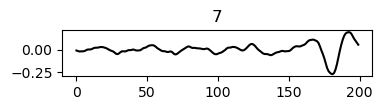

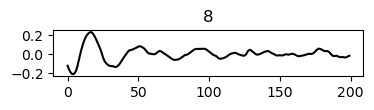

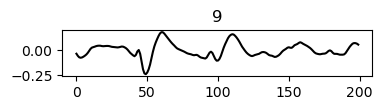

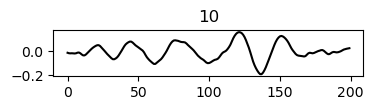

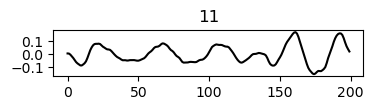

NameError: name 'filepath' is not defined

In [22]:
u_hat = cdl.u_hat_ # spatial
v_hat = cdl.v_hat_ # temporal
z_hat = cdl.z_hat_ # scores
print(v_hat.shape)

for i in range(n_atoms):
    plt.figure(figsize=(4, 0.6))
    plt.plot(v_hat[i, :], 'k')
    plt.title(i)
plt.show()

MAT_FILE = filepath[33:37] + '_' + filepath[38:42] + '_BB_' + str(HI_PASS) + '-' + str(LOW_PASS) + 'Hz_' + str(n_atoms) + '_Atoms_' + str(ATOM_DURATION) + '(s).mat'
savemat('./mat_files/' + MAT_FILE, {"u_hat": u_hat, "v_hat": v_hat, 'z_hat': z_hat})
print(MAT_FILE)

In [ ]:
#z_hat[0].shape
z_hat.shape[1]

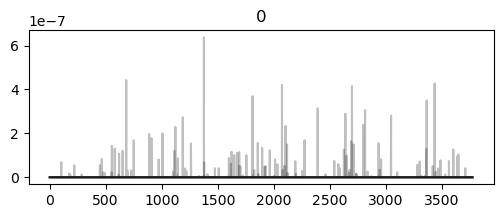

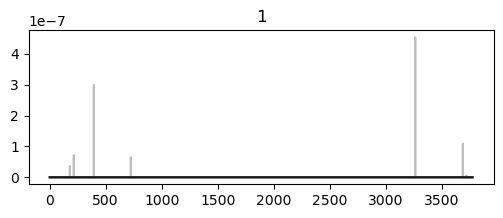

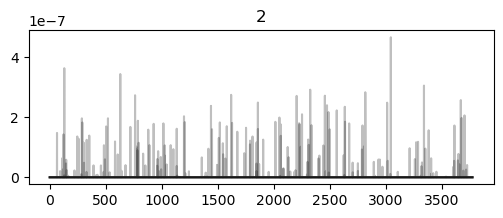

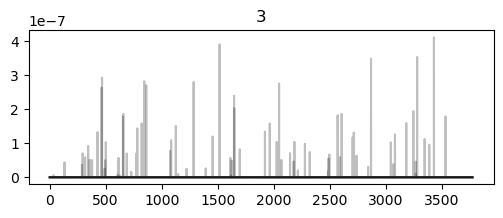

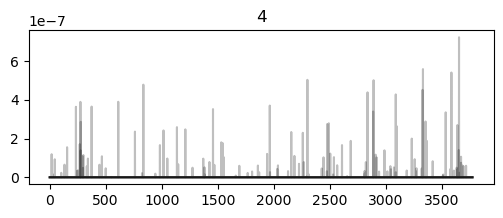

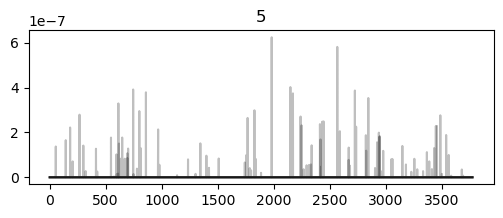

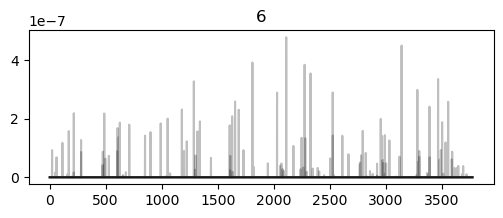

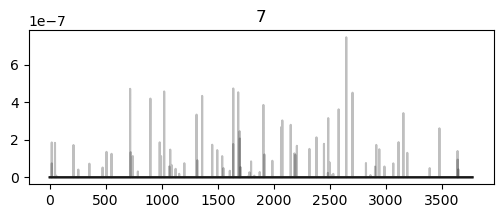

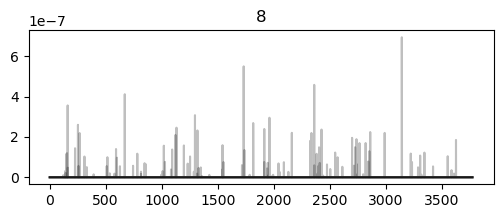

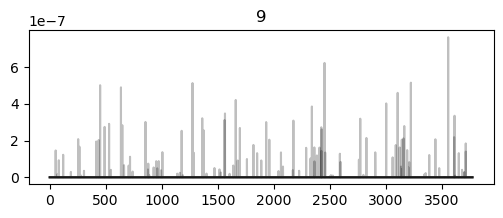

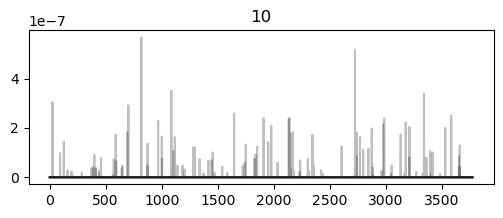

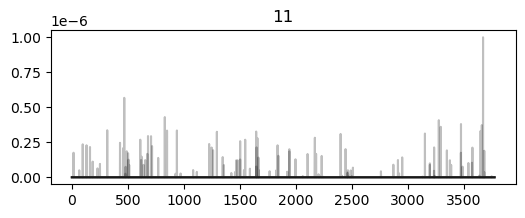

In [118]:
for i in np.arange(z_hat.shape[1]):    
    plt.figure(figsize=(6, 2))
    plt.plot(z_hat[:, i, :].T, 'k', alpha=0.25) 
    plt.title(i)
    
plt.show()

In [ ]:
values = u_hat.shape[9]
# axes should be a 2x2 numpy array
fig, axes = plt.subplots(figsize=(10,10), ncols=2, nrows=2)

# the actual plotting function. 
draw_four_views(axes, values, surf_parcel_names, brain_3d_surfaces, cmap=CMAP, norm_values=Z_LIM)
print(freq_bank[IDX], ' Hz')